# Exercise 08: Random Walks and Diffusion in Networks

**Assignment due:** *April 16 2019*  

In this week's exercise we explore a random walk process, a simple stochastic model for diffusion processes in networks. In the lecture we have seen that random walk processes are not only important as a model for diffusion. Their stationary distribution can also be used to define centrality measures based on the eigenvectors of the transition matrix.

In [1]:
#BOILERPLATE_CODE
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pathpy as pp
import numpy as np
from IPython.display import *
    
from numpy import linalg as npl
import scipy.linalg as spl

import multiprocessing
from joblib import Parallel, delayed
NUM_CORES = multiprocessing.cpu_count()

def random_color():
    return tuple(np.random.rand() for i in range(3))

### Task 1: Simulating random walks

Write a function that computes a (row- or right-stochastic) transition matrix of a random walk process for a given network. The method should work for weighted, unweighted, directed, and undirected networks represented by a `pathpy.Network` object.

In [2]:
def transition_matrix(network):
    adjM = network.adjacency_matrix()
    for i in range(network.ncount()):
        sum_ = np.sum(adjM[i,:])
        if sum_ != 0:
            adjM[i,:] /= sum_
    
    return adjM

In [3]:
print(transition_matrix(pp.algorithms.random_graphs.erdoes_renyi_gnm(10, 15, directed=False)))

  (1, 3)	0.2
  (1, 4)	0.2
  (1, 5)	0.2
  (1, 7)	0.2
  (1, 9)	0.2
  (2, 5)	0.5
  (2, 9)	0.5
  (3, 1)	0.3333333333333333
  (3, 8)	0.3333333333333333
  (3, 9)	0.3333333333333333
  (4, 1)	0.5
  (4, 8)	0.5
  (5, 1)	0.3333333333333333
  (5, 2)	0.3333333333333333
  (5, 7)	0.3333333333333333
  (6, 7)	0.5
  (6, 9)	0.5
  (7, 1)	0.25
  (7, 5)	0.25
  (7, 6)	0.25
  (7, 9)	0.25
  (8, 3)	0.3333333333333333
  (8, 4)	0.3333333333333333
  (8, 9)	0.3333333333333333
  (9, 1)	0.16666666666666666
  (9, 2)	0.16666666666666666
  (9, 3)	0.16666666666666666
  (9, 6)	0.16666666666666666
  (9, 7)	0.16666666666666666
  (9, 8)	0.16666666666666666


Write a function that computes the visitation probability $\pi^{(t)}$ of a random walk after $t$ steps, based on a given initial distribution $\pi^{(0)}$ and a given network topology. You can use built-in `numpy` functions for matrix powers and matrix multiplication. For matrix multiplication, you should have a look at the `dot` function in `numpy`. For the calculation of matrix powers, you should look into the package `numpy.linalg`.

In [4]:
def random_walk(network, t, initial_dist):
    adjM = transition_matrix(network)
    return initial_dist * adjM ** t 

Generate a connected, undirected example network with $10$ nodes and $15$ links and test your function by computing the visitation probabilities after $t=10$ and $t=100$ steps for different initial distributions. 

Do the visitation probabilities converge to a stationary distribution? How do the visitation probabilities after $100$ steps differ across different initial distributions?

In [5]:
n, m = 10, 15

# initial distribution
init_Pos = np.random.randint(n)
init_Dist = np.zeros(n)
init_Dist[init_Pos] = 1

# GNM graph
g_test = pp.algorithms.random_graphs.erdoes_renyi_gnm(10, 15, directed=False)

# time steps
time_steps = 1000

g_test

In [6]:
print(random_walk(g_test, 10, init_Dist))
print(random_walk(g_test, 100, init_Dist))

[0.05373731 0.1640993  0.0907702  0.12213662 0.16946719 0.
 0.14926983 0.08390055 0.08885023 0.07776877]
[0.03571429 0.14285714 0.10714286 0.14285714 0.14285714 0.
 0.14285714 0.10714286 0.10714286 0.07142857]


In [7]:
def plot_random_walk_distribution(network, time_steps=2, sample_size=3):
    fig = plt.figure()
    ax = plt.subplot(111)

    for i in range(sample_size):
        color = random_color()

        # initial distribution
        init_Pos = np.random.randint(network.ncount())
        init_Dist = np.zeros(network.ncount())
        init_Dist[init_Pos] = 1.

        end_Dist = random_walk(network, time_steps, init_Dist)

        ax.plot(end_Dist, 'o--', color=color, label='{:d}'.format(init_Pos))

    ax.set_xlabel(r'Node')
    ax.set_ylabel(r'Probability')

    ax.set_ylim(0, )

    ax.legend(title=r'Start at')

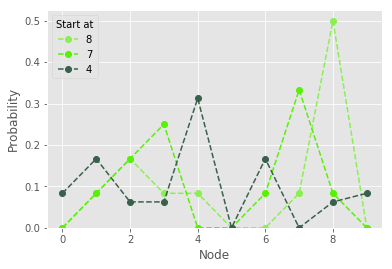

In [8]:
plot_random_walk_distribution(g_test, time_steps=2)

### Task 2: The Total Variation Distance

Using the definition from lecture 8, write a function that computes the total variation distance between two stochastic vectors $\pi$ and $\pi'$.

In [9]:
def tvd(p1, p2):
    return .5 * np.sum(np.abs(p1 - p2))

The following helper function returns the total variation distances between the stationary distribution $\pi$ and the visitation probability $\pi^s$ for $s=0, \ldots, t$ steps of a random walk process.

In [10]:
#BOILERPLATE_CODE
def compute_tvd(network, time_values):
    
    T = transition_matrix(network)
    
    # We use a **right-stochastic matrix**, so what we want to 
    # compute is the **left** eigenvectors (see lecture L08)
    eigenvalues, eigenvectors = spl.eig(T.todense(), left=True, right=False)
    
    # Here we take the **leading eigenvector**, i.e. the eigenvector
    # corresponding to the **largest eigenvalue** of one    
    pi = eigenvectors[:,np.argsort(-eigenvalues)][:,0]
    
    # We make sure that the eigenvector is normalised
    pi = pi/sum(pi)

    # We set the initial distribution
    initial_dist = np.array([0]*network.ncount())
    initial_dist[0] = 1

    # We calculate the total variation dist after each step
    def get_tvd(s):
        _x = initial_dist * T ** s 
        return tvd(pi,_x)
    tvds = Parallel(n_jobs=NUM_CORES)(delayed(get_tvd)(s) for s in time_values)
        
    return tvds

Use the function above to calculate and plot the evolution of the total variation distance for the undirected example network shown in lecture 08. 

In [11]:
def plot_tvd(network, time_values):
    fig = plt.figure()
    ax = plt.subplot(111)
    
    ax.plot(time_values,compute_tvd(network, time_values))
    
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'Time')
    ax.set_ylabel(r'Total variation distance')

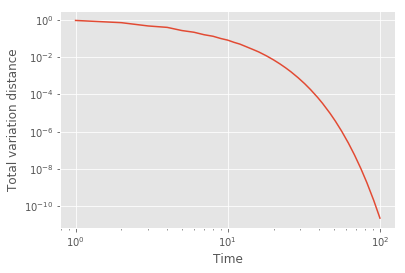

In [12]:
plot_tvd(g_test, np.logspace(0,2,dtype=int))

### Task 3: Network Topology and Diffusion Speed

Using code from previous exercises or corresponding `pathpy` functions, generate the following six random networks:

   1. an Erdös-Renyi network with $n=200$ nodes and $m=400$ links
   2. an Erdös-Renyi network with $n=200$ nodes and $m=600$ links
   3. a modular network consisting of two $5$-regular random networks with $100$ nodes each, which are joined together by crossing the endpoints of two arbitrary chosen links
   4. a scale-free network with $200$ nodes and exponent $\gamma=2.7$
   5. a Watts-Strogatz ring lattice with the parameters $n=200$, $m=5$ and rewiring probability $p=0$
   6. a Watts-Strogatz small-world network with the parameters $n=200$, $m=5$ and rewiring probability $p=0.05$

### Task 3.1 Diffusion Speed in Random Networks

For each of the six networks use the helper function from Task 2 to plot the evolution of the total variation distance $\delta(\pi^{(t)}, \pi)$ for $t \in \left[0, 500\right]$ where $\pi$ is the stationary distribution.

In [13]:
total_time = np.logspace(0,5,dtype=int)

**Experiment 1**: Erdös-Renyi network with 200 nodes and 400 links

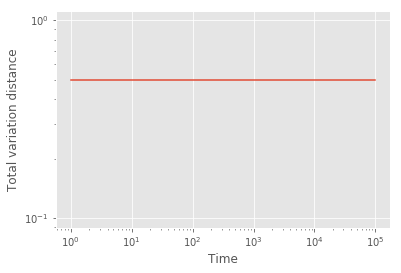

In [14]:
plot_tvd(
    pp.algorithms.random_graphs.erdoes_renyi_gnm(200, 400),
    total_time
)

**Experiment 2**: Erdös-Renyi network with 200 nodes and 600 links

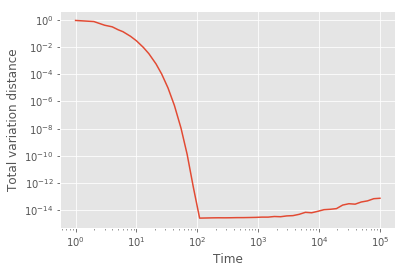

In [15]:
plot_tvd(
    pp.algorithms.random_graphs.erdoes_renyi_gnm(200, 600),
    total_time
)

**Experiment 3**: Modular network consisting of two 5-regular random networks with a total of 200 nodes

In [16]:
g1 = pp.algorithms.random_graphs.random_k_regular(k=5, n=100, node_names=range(100))
g2 = pp.algorithms.random_graphs.random_k_regular(k=5, n=100, node_names=range(100, 200))

# Add g2 to g1
g3 = g1 + g2
    
number_of_additional_edges = 3

for i in range(number_of_additional_edges):
    rand1 = np.random.choice(list(g1.nodes.keys()))
    rand2 = np.random.choice(list(g2.nodes.keys()))

    g3.add_edge(rand1, rand2)

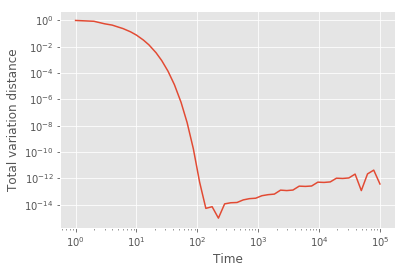

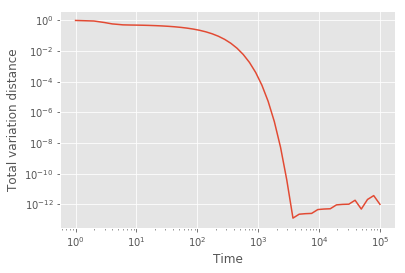

In [17]:
plot_tvd(
    g2,
    total_time
)

plot_tvd(
    g3,
    total_time
)

**Experiment 4**: A scale-free network with power law exponent 2.7 and 200 nodes

151


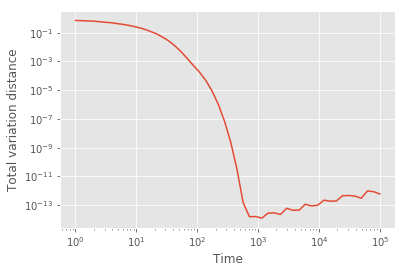

In [18]:
degree_sequence = []

while not pp.algorithms.random_graphs.is_graphic_sequence(degree_sequence):
    degree_sequence = np.random.zipf(2.7, size=200)
    
g_sf = pp.algorithms.random_graphs.molloy_reed(degree_sequence=degree_sequence)
pp.algorithms.components.reduce_to_gcc(g_sf)
print(g_sf.ncount())

plot_tvd(
    g_sf,
    total_time
)

**Experiment 5**: A Watts-Strogatz ring lattice with n=200, m=5 and p=0. 

In [19]:
# Export from exercise 04
def WattsStrogatz(n, s, p):
    g = pp.Network()
    for i in range(n):
        g.add_node(str(i))
    
    # construct a ring lattice (dimension 1)
    for i in range(n):
        for j in range(1,s+1):
            g.add_edge(str(i),str((i+j)%n))

    if p==0:
        # nothing to do here
        return g
    
    # Rewire each link with probability p
    _edges = list(g.edges)
    for v,w in _edges:
        if np.random.rand()<p:                
            # Delete original link and remember source node
            g.remove_edge(v,w)

            # Find new random tgt, which is not yet connected to src
            new_target = None
            
            # This loop repeatedly chooses a random target until we find 
            # a target not yet connected to src. Note that this could potentially
            # result in an infinite loop depending on parameters.
            while new_target == None:
                x = str(np.random.randint(n))
                if not x is v and not x in g.successors[v]:
                    new_target = x
            g.add_edge(v, new_target)                    
    return g

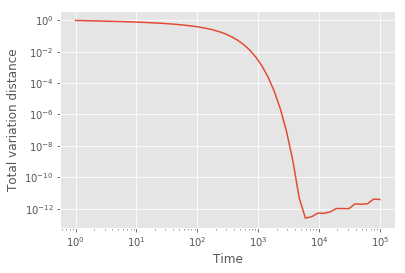

In [20]:
plot_tvd(
    WattsStrogatz(200, 5, .0),
    total_time
)

**Network 6**: A Watts-Strogatz small-world network with n = 200, m=5 and p = 0.05

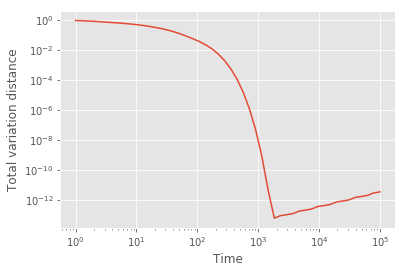

In [21]:
plot_tvd(
    WattsStrogatz(200, 5, .05),
    total_time
)

### Task 3.2 Interpretation of results

Interpret your results by answering the following questions: 

1. In which network is diffusion fastest and in which is it slowest?
2. How does the number of links in a random graph affect diffusion speed?
3. Do you see any interesting patterns in the evolution of the total variation distance over time?
4. How does a change of the rewiring parameter $p$ of the Watts-Strogatz model affect the speed of diffusion?

### Task 3.3 Networks with maximum diffusion speed

Consider a network with 50 nodes. Which network topology will have the fastest possible diffusion speed? Test your hypothesis with an experiment.

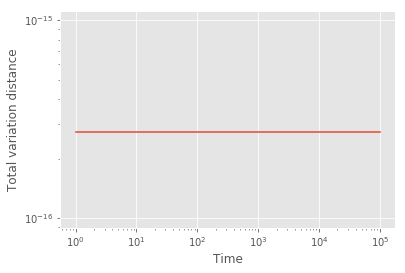

In [22]:
plot_tvd(
    pp.algorithms.random_graphs.erdoes_renyi_gnp(n=50, p=1),
    total_time
)